<a href="https://colab.research.google.com/github/vjacobsen/Liquor-Sales-Inventory-Forecast/blob/main/Liquor_Safety_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safety Stock Calculation

The approach used considers forecast error as the only factor requiring buffer inventory. 

Also, forecast error is assumed to be normally distributed.

In a real world scenario, additional variables such as supplier lead time would also need to be added.

In [1]:
import os
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

#### Query
This is the forecast table loaded to Google Cloud in the previous notebook

In [2]:
### Provide your credentials to the runtime
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
print('Authenticated')

project_id = 'iowa-liquor-sales-266301'
bq_dataset_name = "forecasting"

# Construct a BigQuery client object
client = bigquery.Client(project = project_id,)

Authenticated


In [91]:
# Run query
forecasts_query = client.query('''
SELECT *
FROM 
`iowa-liquor-sales-266301.forecasting.ml_forecasts`
''').to_dataframe()

### Transform data

Data is grouped by month-year and forecast error is calulated at this level

In [92]:
# Convert string to date
forecasts['date'] = pd.to_datetime(forecasts_query['date'])

# Number to object
forecasts['forecast_key'] = forecasts['forecast_key'].astype(str)

# Remove safety stock column if exists (only needed if cell is rerun)
try:
  forecasts.drop(columns=['safety_stock'],inplace=True)
except: 
  pass

# Group by month-year
forecasts['month_year'] = forecasts['date'].dt.month.astype(str) +  "_" + forecasts['date'].dt.year.astype(str)
monthly_forecasts = forecasts.groupby(['forecast_key','month_year','type']).agg({"sales_bottles":sum,"forecast":sum}).reset_index()

target_value = 'sales_bottles'

# Historical data
historical = monthly_forecasts[monthly_forecasts['type']!='forecast']

# Error
historical['error'] = historical['forecast'] - historical[target_value] 

historical.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,forecast_key,month_year,type,sales_bottles,forecast,error
0,100015,10_2017,train,291.0,171.0,-120.0
1,100015,10_2018,train,188.0,174.0,-14.0
2,100015,10_2019,train,0.0,153.0,153.0
4,100015,10_2020,test,93.0,135.0,42.0
6,100015,11_2017,train,136.0,75.0,-61.0


### Error distribution
We'll look at percetage error to allow for better comparison

In [39]:
# Calculate MAPE
historical['mape_pcnt'] = (np.divide(historical['error'],historical['sales_bottles']).abs()).round(2)

# Infinite MAPE values are generated when error is 0, replace with 0
non_infinite_mask = ~historical['mape_pcnt'].isin([np.inf,-np.inf])

historical['mape_pcnt'] = historical['mape_pcnt'].where(non_infinite_mask,other=0)

historical.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,forecast_key,month_year,type,sales_bottles,forecast,error,mape_pcnt
1,4796,10_2020,test,159.0,204.0,45.0,0.28
7,4796,3_2020,train,145.0,117.0,-28.0,0.19
9,4796,4_2020,train,206.0,136.0,-70.0,0.34
11,4796,5_2020,train,161.0,152.0,-9.0,0.06
13,4796,6_2020,train,135.0,178.0,43.0,0.32


In [45]:
# Summary
historical.describe().round(2)

,forecast_key,sales_bottles,forecast,error,mape_pcnt
count,5924.00,5924.00,5924.00,5924.00,5499.00
mean,263281.12,2327.72,2286.00,-41.72,0.41
std,372901.35,11301.21,11212.37,969.62,3.43
min,4796.00,0.00,-517.00,-17425.00,0.00
25%,38089.00,69.00,80.00,-56.00,0.05
50%,69666.00,338.00,340.00,0.00,0.14
75%,89916.00,1234.00,1158.50,52.00,0.34
max,989289.00,186832.00,187566.00,11955.00,175.17


Looking at the summary table, we notice some extreme error values

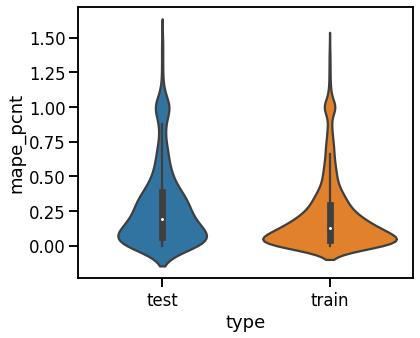


 118 item-months have error above 150%

 They represent 2.0% of total items-month keys


In [84]:
sns.set_context('talk')

# Violin plot without extreme values
data = historical[historical['mape_pcnt']<1.5]

# Plot
plt.figure(figsize=(6,5))
sns.violinplot(x=data['type'],y=data['mape_pcnt'])
plt.show()

# How many item - months have MAPE error above 150%?
print("\n {} item-months have error above 150%".format(len(historical[historical['mape_pcnt']>1.5])))

percent_of_total =  (len(historical[historical['mape_pcnt']>1.5])/len(historical))*100
print("\n They represent {}% of total items-month keys".format(round(percent_of_total,1)))

### Calculate Reorder Quantity

We'll use the Minimum Order Quantity formula:

$ EOQ = \sqrt{2 *\dfrac{Annual Demand * Cost per Order}{Annual Holding Cost  per Unit}} $


* Annual holding cost is set at 15% of the bottle's cost
* The bottle cost is 35% of the retail value

We must first get the average bottle price by querying the sales data in the last year


In [87]:
item_price = client.query('''

SELECT 
item_number,
item_description,
category_name, 
SUM(sale_dollars)/SUM(bottles_sold) as avg_price

FROM `bigquery-public-data.iowa_liquor_sales.sales`

WHERE 
date > DATE_SUB((SELECT MAX(date) FROM `bigquery-public-data.iowa_liquor_sales.sales`), INTERVAL 1 YEAR) AND 
vendor_number = '421'

GROUP BY
item_number, 
category_name, 
item_description

''').to_dataframe()

item_price.sample(5)


,item_number,item_description,category_name,avg_price
262,916850,Blantons Buy the Barrel,Straight Bourbon Whiskies,43.130000
76,36978,Nikolai Vodka,American Vodkas,10.101968
159,12861,Rich & Rare Caramel Mini,Canadian Whiskies,9.000000
75,37414,Popov 80prf,American Vodkas,4.500000
20,43621,Myers's Original Dark Rum,Aged Dark Rum,14.683084


In [89]:
historical.merge(item_price,left_on='forecast_key',right_on='item_number')

ValueError: ignored

### Optimize Safety Stock

We'll optimize safety stock by minimizing the cost function defined as:

> $C(x) = SS(sl)* IC + (1-sl) * FCST$

Where:

* _SS: Total safety stock for all items, a function of the service level (sl)_   
* _sl: Service level, a decimal value between 0.01 and 1_  
* _IC: Inventory carrying cost_  
* _FCST: Sales forecast for the period, used to estimate lost sales_  

  

---



For simplicity purposes, inventory holding cost is defined as 15% of the inventory's value per year.





Calculate Safety Stock

In [ ]:
# Desired service level
proba = .975

# Calculate safety stock for each key
def safety_stock_func(df):
    
    # variables
    k = stats.norm.ppf(proba) 
    std = np.std(df['error'])
    
    # safety stock formula
    ss_calculation = k * std
    print(k)
    
    return ss_calculation

safety_stock = historical.groupby('forecast_key').apply(safety_stock_func)
safety_stock = pd.DataFrame(safety_stock,columns=['safety_stock']).round()

# Add safety stock to dataset
forecasts = forecasts.set_index("forecast_key").join(safety_stock)

print('\n SS Calcualted! \n Median SS: \n {}'.format(round(safety_stock['safety_stock'].median())) )

1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.959963984540054
1.95996398

KeyError: ignored

### Plot

Number of Obs: 62


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


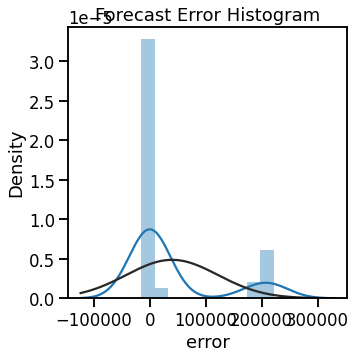

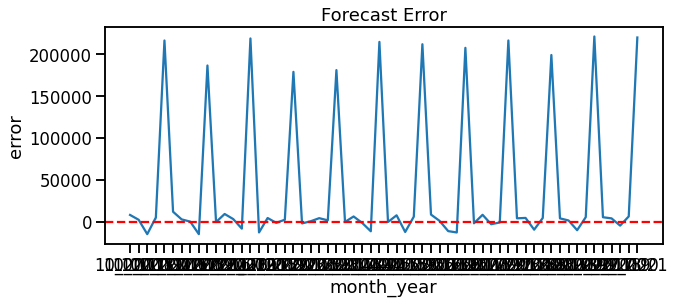

In [ ]:
from scipy.stats import norm

# Plot
sns.set_context('talk')
subset = historical[historical['forecast_key'].isin(historical['forecast_key'].drop_duplicates().sample())] 
subset = historical[historical['forecast_key'].isin(['64870'])] 
print('Number of Obs:',len(subset))

# Histogram
plt.figure(figsize=(5,5))
plt.title('Forecast Error Histogram')
sns.distplot(subset['error'],bins=10,fit=norm)
plt.show()

# Error plot
plt.figure(figsize=(10,4))
plt.title('Forecast Error')
sns.lineplot(y='error',x='month_year', data=subset)
plt.axhline(0, ls='--',color='red')
plt.show()

## Export to BigQuery

In [ ]:
from google.cloud import bigquery

# Save table locally
forecasts.to_csv('ss_forecasts.csv')

# Specify project and destination 
project_id = 'iowa-liquor-sales-266301'
bq_dataset_name = "forecasting"

# Local path of file to be uploaded
forecasts_path = "/content/ss_forecasts.csv"

file_paths = [forecasts_path]
table_names = ["ml_forecasts"]

# Construct a BigQuery client object
client = bigquery.Client(project = project_id)

# Batch load tables
for file_path,tb_name in zip(file_paths,table_names):
  
  table_id = "{}.{}.{}".format(project_id,bq_dataset_name,tb_name)

  job_config = bigquery.LoadJobConfig(
      source_format=bigquery.SourceFormat.CSV, 
      skip_leading_rows=1, 
      autodetect=True,
  )

  job_config.write_disposition = 'WRITE_TRUNCATE' # Replace data

  with open(file_path, "rb") as source_file:
      job = client.load_table_from_file(source_file, table_id,job_config=job_config)
      
  job.result()  # Waits for the job to complete.

  table = client.get_table(table_id)  # Make an API request.

  print(
      "Loaded {} rows and {} columns to {}".format(
          table.num_rows, len(table.schema), table_id
      )
  )

Loaded 232097 rows and 19 columns to iowa-liquor-sales-266301.forecasting.ml_forecasts
